In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Import, load, and visualize original images and homography

Original Image 1:
Shape: (759, 1830)


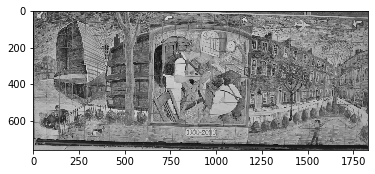


Original Image 2:
Shape: (653, 986)


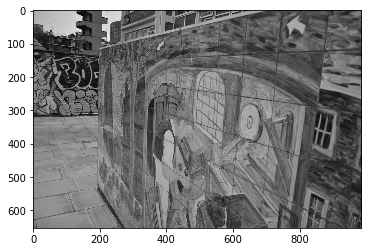


Original Ground Truth Homography:
[[ 1.2717e-02  1.4394e-02  1.9352e+02]
 [-1.2386e-01  6.0301e-01  1.2670e+02]
 [-6.3953e-04  7.9665e-05  1.0012e+00]]


In [2]:
path_to_image1 = "1.ppm"
path_to_image2 = "5.ppm"
path_to_homography = "H_1_5"
target_size = [480, 640]

image1 = cv2.imread(path_to_image1, 0)
image2 = cv2.imread(path_to_image2, 0)
homography = np.loadtxt(path_to_homography)

image1show = np.dstack([image1, image1, image1])
image2show = np.dstack([image2, image2, image2])

print("Original Image 1:")
print("Shape:", image1.shape)
plt.imshow(image1show)
plt.show()

print("\nOriginal Image 2:")
print("Shape:", image2.shape)
plt.imshow(image2show)
plt.show()

print("\nOriginal Ground Truth Homography:")
print(homography)

# Recreate HPatches pre-processing

Scale1: 0.6324110671936759
Aspect-ratio preserving resized Image 1:
Shape: (480, 1157)


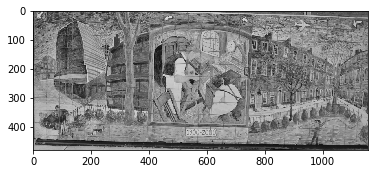

Resized and cropped Image 1:
Shape: (480, 640)


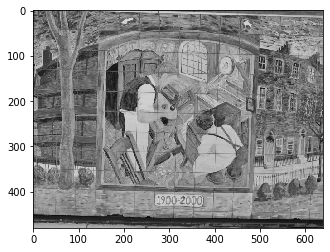



Scale2: 0.7350689127105666
Aspect-ratio preserving resized Image 2:
Shape: (480, 724)


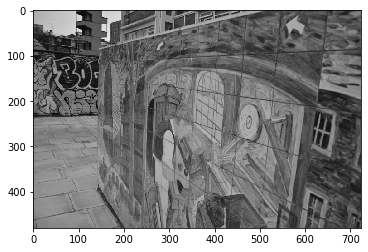

Resized and cropped Image 2:
Shape: (480, 640)


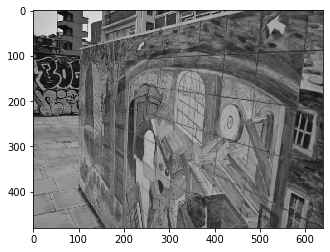

In [3]:
fit_height1 = target_size[0]/image1.shape[0] > target_size[1]/image1.shape[1]
scale1 = target_size[0]/image1.shape[0] if fit_height1 else target_size[1]/image1.shape[1]

fit_height2 = target_size[0]/image2.shape[0] > target_size[1]/image2.shape[1]
scale2 = target_size[0]/image2.shape[0] if fit_height2 else target_size[1]/image2.shape[1]


#Aspect-ratio preserving resize, to simulate tf.image.resize_images()
new_size1 = (int(image1.shape[1]*scale1), int(image1.shape[0]*scale1))
img1resized = cv2.resize(image1, new_size1)

new_size2 = (int(image2.shape[1]*scale2), int(image2.shape[0]*scale2))
img2resized = cv2.resize(image2, new_size2)

#To simulate tf.image.resize_image_with_crop_or_pad()
if fit_height1:
    halfcrop1 = int((img1resized.shape[1] - target_size[1]) /2)
    img1cropped = img1resized[:, halfcrop1:halfcrop1+target_size[1]]
else:
    halfcrop1 = int((img1resized.shape[0] - target_size[0]) /2)
    img1cropped = img1resized[halfcrop1:halfcrop1+target_size[0], :]

if fit_height2:
    halfcrop2 = int((img2resized.shape[1] - target_size[1]) /2)
    img2cropped = img2resized[:, halfcrop2:halfcrop2+target_size[1]]
else:
    halfcrop2 = int((img2resized.shape[0] - target_size[0]) /2)
    img2cropped = img2resized[halfcrop2:halfcrop2+target_size[0], :]


img1resizedshow = np.stack([img1resized, img1resized, img1resized], axis=2)
img2resizedshow = np.stack([img2resized, img2resized, img2resized], axis=2)
img1croppedshow = np.stack([img1cropped, img1cropped, img1cropped], axis=2)
img2croppedshow = np.stack([img2cropped, img2cropped, img2cropped], axis=2)

print("Scale1:", scale1)
print("Aspect-ratio preserving resized Image 1:")
print("Shape:", img1resized.shape)
plt.imshow(img1resizedshow)
plt.show()
print("Resized and cropped Image 1:")
print("Shape:", img1cropped.shape)
plt.imshow(img1croppedshow)
plt.show()

print("\n\nScale2:", scale2)
print("Aspect-ratio preserving resized Image 2:")
print("Shape:", img2resized.shape)
plt.imshow(img2resizedshow)
plt.show()
print("Resized and cropped Image 2:")
print("Shape:", img2cropped.shape)
plt.imshow(img2croppedshow)
plt.show()

## Bug 1: Ignored crop

Original adapted Homography:
[[ 1.27170000e-02  1.43940000e-02  1.22384190e+02]
 [-1.23860000e-01  6.03010000e-01  8.01264822e+01]
 [-1.01125681e-03  1.25970281e-04  1.00120000e+00]]

Image 1 warped with original adapted homography:
Shape: (480, 640)


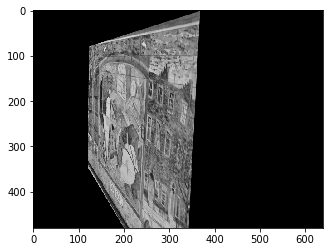

Resized and cropped Image 2:
Shape: (480, 640)


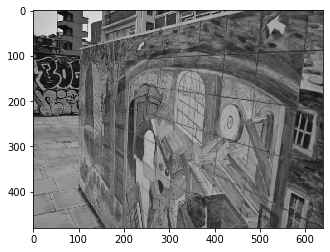

Resized and left/top cropped Image 1:
Shape: (480, 640)


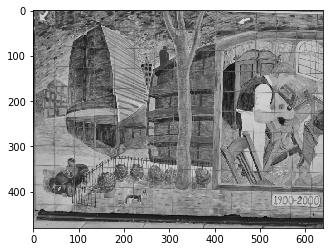

Left/top cropped Image 1 warped with original adapted homography:
Shape: (480, 640)


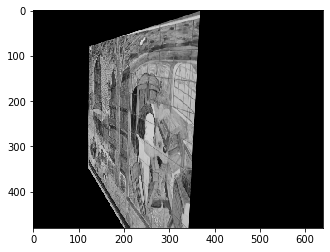

In [4]:
#Original homography adaptation
down_scale = np.diag(np.stack([1./scale1, 1./scale1, 1.]))
up_scale = np.diag(np.stack([scale1, scale1, 1.]))
real_H = up_scale @ homography @ down_scale
print("Original adapted Homography:")
print(real_H)

#Do a left/top crop of resized image1 instead of central crop for comparison
if fit_height1:
    img1cropped2 = img1resized[:, :target_size[1]]
else:
    img1cropped2 = img1resized[:target_size[0], :]

warped_img1 = cv2.warpPerspective(img1cropped, real_H, (img2cropped.shape[1], img2cropped.shape[0]))
warped_img1_2 = cv2.warpPerspective(img1cropped2, real_H, (img2cropped.shape[1], img2cropped.shape[0]))
    

img1cropped2show = np.stack([img1cropped2, img1cropped2, img1cropped2], axis=2)
warped_img1show = np.stack([warped_img1, warped_img1, warped_img1], axis=2)
warped_img1_2show = np.stack([warped_img1_2, warped_img1_2, warped_img1_2], axis=2)

print("\nImage 1 warped with original adapted homography:")
print("Shape:", warped_img1.shape)
plt.imshow(warped_img1show)
plt.show()

print("Resized and cropped Image 2:")
print("Shape:", img2cropped.shape)
plt.imshow(img2croppedshow)
plt.show()

print("Resized and left/top cropped Image 1:")
print("Shape:", img1cropped2.shape)
plt.imshow(img1cropped2show)
plt.show()

print("Left/top cropped Image 1 warped with original adapted homography:")
print("Shape:", warped_img1_2.shape)
plt.imshow(warped_img1_2show)
plt.show()

## Bug 2: Scale Mismatch

Rectified adapted Homography:
[[ 1.27170000e-02  1.43940000e-02  1.25665176e+02]
 [-1.23860000e-01  6.03010000e-01  4.81706022e+01]
 [-1.01125681e-03  1.25970281e-04  7.40295742e-01]]

Image 1 warped with rectified adapted homography:
Shape: (480, 640)


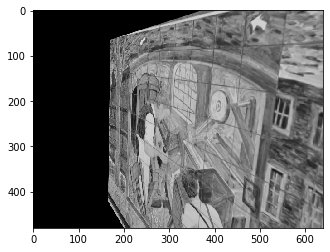

Resized and cropped Image 2:
Shape: (480, 640)


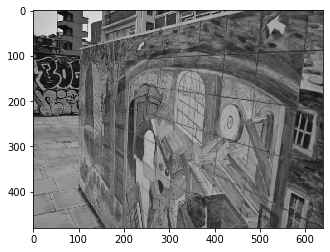

Above 2 images superimposed:


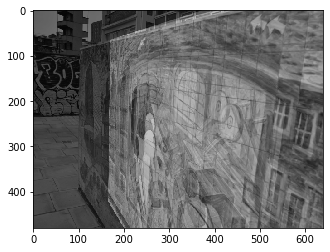

In [5]:
#Add translation into homography adaptation
tx=0
ty=0
if fit_height1:
    tx = halfcrop1
else:
    ty = halfcrop1
down_scale = np.diag(np.stack([1./scale1, 1./scale1, 1.]))
up_scale = np.diag(np.stack([scale1, scale1, 1.]))
translation = np.array([[1, 0, tx],
                        [0, 1, ty],
                        [0, 0, 1]], np.float32)
correct_real_H = up_scale @ homography @ down_scale @ translation
print("Rectified adapted Homography:")
print(correct_real_H)

correct_warped_img1 = cv2.warpPerspective(img1cropped, correct_real_H, (img2cropped.shape[1], img2cropped.shape[0]))

correct_warped_img1show = np.stack([correct_warped_img1, correct_warped_img1, correct_warped_img1], axis=2)

superimposed = cv2.addWeighted(correct_warped_img1show, 0.5, img2croppedshow, 0.5, 0)

print("\nImage 1 warped with rectified adapted homography:")
print("Shape:", correct_warped_img1.shape)
plt.imshow(correct_warped_img1show)
plt.show()

print("Resized and cropped Image 2:")
print("Shape:", img2cropped.shape)
plt.imshow(img2croppedshow)
plt.show()

print("Above 2 images superimposed:")
plt.imshow(superimposed)
plt.show()

Correctly resized Image 2:
Shape: (412, 623)


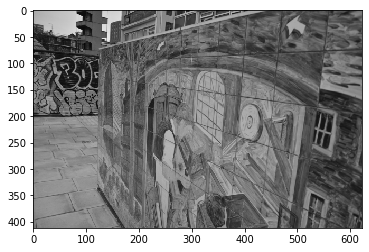

Correct superimposed images:


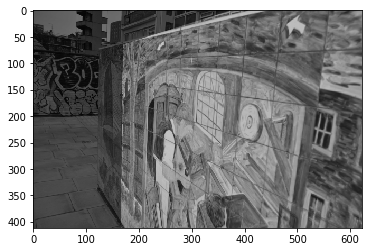

In [6]:
#Resize image2 using scale of image1
correct_new_size2 = (int(image2.shape[1]*scale1), int(image2.shape[0]*scale1))
correct_img2resized = cv2.resize(image2, correct_new_size2)

correctsized_warped_img1 = cv2.warpPerspective(img1cropped, correct_real_H, (correct_img2resized.shape[1], correct_img2resized.shape[0]))

correct_img2resizedshow = np.stack([correct_img2resized, correct_img2resized, correct_img2resized], axis=2)
correctsized_warped_img1show = np.stack([correctsized_warped_img1, correctsized_warped_img1, correctsized_warped_img1], axis=2)

superimposed2 = cv2.addWeighted(correctsized_warped_img1show, 0.5, correct_img2resizedshow, 0.5, 0)

print("Correctly resized Image 2:")
print("Shape:", correct_img2resized.shape)
plt.imshow(correct_img2resizedshow)
plt.show()

print("Correct superimposed images:")
plt.imshow(superimposed2)
plt.show()

## Bug 3: Swapped axes

Original real_warped_corners (y, x):
[[ 169.74996414   65.06940329]
 [ 164.30855413  528.14190597]
 [ 514.86791201  -43.60365448]
 [ 419.00984879 1112.26651274]]


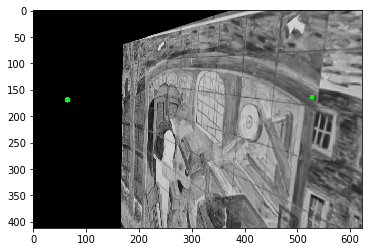

In [7]:
#Original corner definition
shape = target_size
corners = np.array([[0, 0, 1],
                    [0, shape[1] - 1, 1],
                    [shape[0] - 1, 0, 1],
                    [shape[0] - 1, shape[1] - 1, 1]])
real_warped_corners = np.dot(corners, np.transpose(correct_real_H))
real_warped_corners = real_warped_corners[:, :2] / real_warped_corners[:, 2:]
print("Original real_warped_corners (y, x):")
print(real_warped_corners)

#Draw out the corners if they are within the frame
correctsized_warped_img1_with_cornersshow = np.copy(correctsized_warped_img1show)
for corner in real_warped_corners:
    corner = corner.astype('int')
    if np.all(corner >= [0, 0]) and np.all(corner < correct_img2resized.shape):
        cv2.circle(correctsized_warped_img1_with_cornersshow, (corner[1], corner[0]), radius=5, color=(0,255,0), thickness=-1)
    
plt.imshow(correctsized_warped_img1_with_cornersshow)
plt.show()

Rectified real_warped_corners (x, y):
[[ 169.74996414   65.06940329]
 [1421.75968579 -329.17182827]
 [ 165.56835233  420.93110938]
 [ 910.92900114 1669.65707404]]


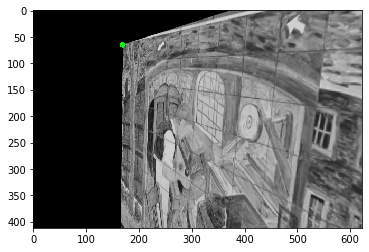

In [8]:
#Rectified corner definition
shape = target_size
correct_corners = np.array([[0, 0, 1],
                            [shape[1] - 1, 0, 1],
                            [0, shape[0] - 1, 1],
                            [shape[1] - 1, shape[0] - 1, 1]])
correct_real_warped_corners = np.dot(correct_corners, np.transpose(correct_real_H))
correct_real_warped_corners = correct_real_warped_corners[:, :2] / correct_real_warped_corners[:, 2:]

print("Rectified real_warped_corners (x, y):")
print(correct_real_warped_corners)

#Draw out the corners if they are within the frame
correctsized_warped_img1_with_correct_cornersshow = np.copy(correctsized_warped_img1show)
for corner in correct_real_warped_corners:
    corner = corner.astype('int')
    if np.all(corner >= [0, 0]) and np.all(corner < [correct_img2resized.shape[1], correct_img2resized.shape[0]]):
        cv2.circle(correctsized_warped_img1_with_correct_cornersshow, (corner[0], corner[1]), radius=5, color=(0,255,0), thickness=-1)
    
plt.imshow(correctsized_warped_img1_with_correct_cornersshow)
plt.show()